<a href="https://colab.research.google.com/github/Ksenyff/AI/blob/main/experiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Документы:
- [плана эксперимента](https://docs.google.com/document/d/1Tq9zMxdcs9TdlMVaGjWb2ADOzXMHOc_-MIURE7vtoYs/edit?usp=sharing)


# Дано:
- 540 экспериментов
- 3 фактора и 3 уровня: 3³ = 27 уникальных комбинаций
- в среднем 20 повторов на комбинацию: 540 / 27 = 20

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
results_path = "/content/output2v2.csv"

df = pd.read_csv(results_path, names=["index", "max_vel_x", "max_vel_y","max_vel_theta", "nav_status", "nav_time", ], header=0)
df.shape

label_encoder = LabelEncoder()

def get_correct_status(row):
    t = row['nav_time']
    s = row['nav_status']
    if t >= 60.0:
        return "CANCELED"
    else:
        return "SUCCEEDED"


df['nav_status'] = df.apply(get_correct_status, axis=1)
df['nav_status_code'] = LabelEncoder().fit_transform(df['nav_status'])
df

,index,max_vel_x,max_vel_y,max_vel_theta,nav_status,nav_time,nav_status_code
0,1,1.0,0.2,2.5,SUCCEEDED,41.443,1
1,2,0.2,1.0,1.5,CANCELED,60.008,0
2,3,1.0,0.6,0.5,SUCCEEDED,33.914,1
3,4,0.2,0.6,2.5,CANCELED,60.007,0
4,5,1.0,0.2,1.5,SUCCEEDED,35.183,1
...,...,...,...,...,...,...,...
534,535,0.2,1.0,1.5,SUCCEEDED,55.170,1
535,536,0.6,0.2,1.5,SUCCEEDED,33.943,1
536,537,0.2,1.0,0.5,SUCCEEDED,39.859,1
537,538,0.6,0.2,0.5,SUCCEEDED,32.833,1


## Корреляционный анализ

In [ ]:
df_success = df[df['nav_status'] == 'SUCCEEDED'].copy()
print(f"Всего: {len(df)} | Успешных: {len(df_success)} ({len(df_success)/len(df)*100:.1f}%)")

Всего: 539 | Успешных: 355 (65.9%)


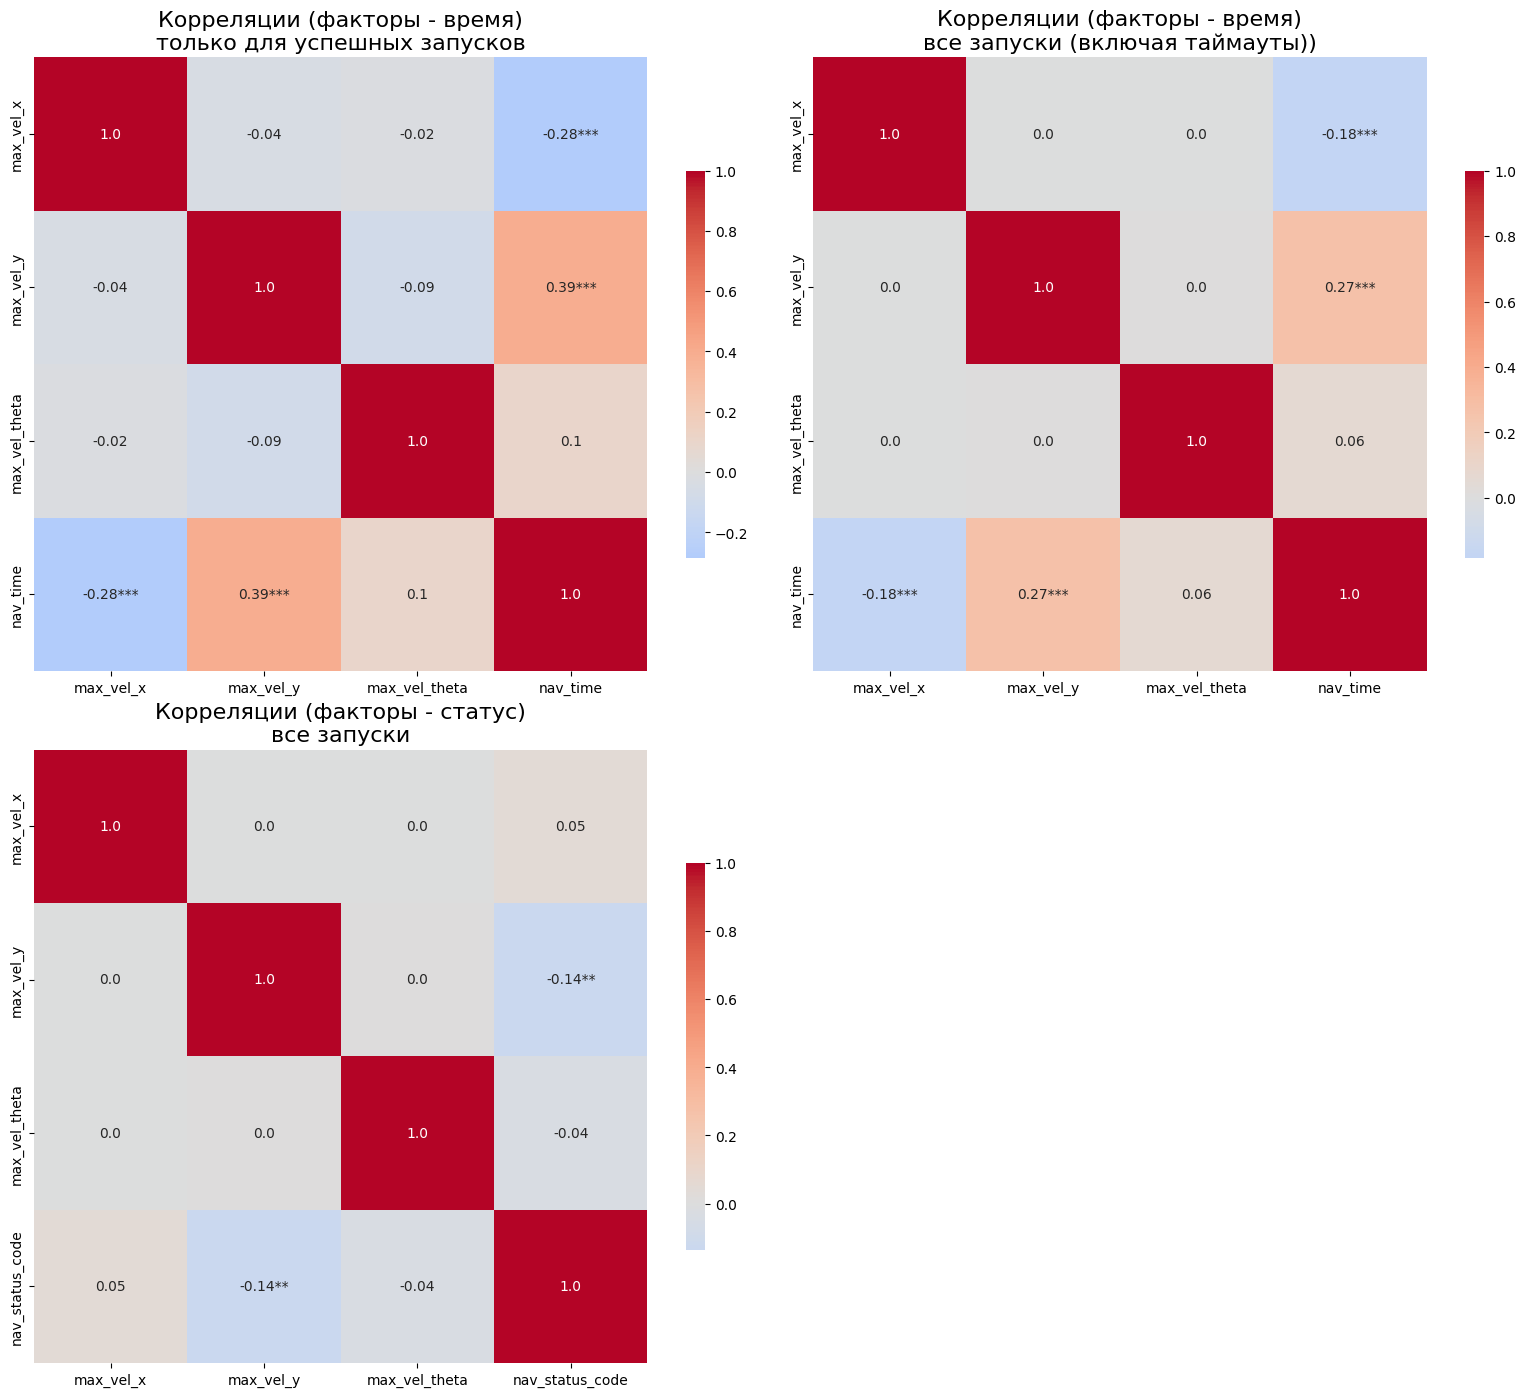

In [ ]:
import seaborn as sns
from scipy import stats

factors = ['max_vel_x', 'max_vel_y', 'max_vel_theta']
df_all = df[factors + ['nav_time', 'nav_status_code']].copy()
df_success = df[df['nav_status_code'] == 1][factors + ['nav_time']].copy()

def plot_heatmap(ax, df, title, method='spearman', method_func=stats.spearmanr):
    # Матрица корреляций
    corr = df.corr(method=method)

    # Матрица p-значений
    pvals = np.ones_like(corr)
    cols = df.columns
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i != j:
                _, p = method_func(df[col1], df[col2])
                pvals[i, j] = p
    pvals = pd.DataFrame(pvals, index=cols, columns=cols)

    annot = corr.round(2).astype(str)
    for i in range(len(cols)):
        for j in range(len(cols)):
            p = pvals.iloc[i, j]
            stars = ''
            if p < 0.001:
                stars = '***'
            elif p < 0.01:
                stars = '**'
            elif p < 0.05:
                stars = '*'
            annot.iloc[i, j] = annot.iloc[i, j] + stars

    sns.heatmap(
        corr,
        annot=annot,
        fmt='',
        cmap='coolwarm',
        center=0,
        square=True,
        cbar_kws={'shrink': 0.6},
        ax=ax
    )
    ax.set_title(title, fontsize=16)

fig, ax = plt.subplots(2, 2, figsize=(16, 14))

plot_heatmap(ax[0, 0], df_success,
             "Корреляции (факторы - время)\nтолько для успешных запусков")

plot_heatmap(ax[0, 1], df_all[factors + ['nav_time']],
             "Корреляции (факторы - время)\nвсе запуски (включая таймауты))")

plot_heatmap(ax[1, 0], df_all[factors + ['nav_status_code']],
             "Корреляции (факторы - статус)\nвсе запуски")

fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

## Регрессионный анализ

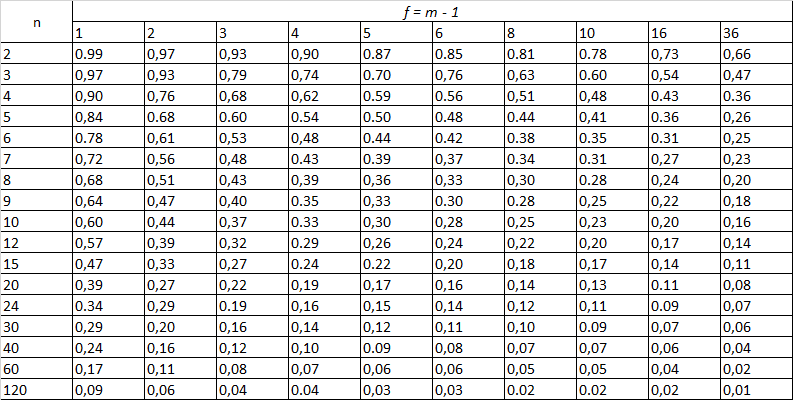

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
df['true_success'] = (df['nav_time'] < 60.0).astype(int)
df['success_time'] = df['nav_time'].where(df['true_success'] == 1)

grouped = df.groupby(['max_vel_x', 'max_vel_y', 'max_vel_theta'])

variances = []
ns = []
for name, group in grouped:
    succ = group[group['true_success'] == 1]['nav_time']
    if len(succ) >= 2:
        variances.append(succ.var(ddof=1))
        ns.append(len(succ))

variances = np.array(variances)
C = variances.max() / variances.sum()  # Кохрена
df1 = 1
df2 = len(ns) - 1
# Табличное C_крит ≈ 0.21 (для k=27, n=10,)
C_critical = 0.21
print(f"Кохрена C = {C:.4f} (табличное ≈ {C_critical}) - ", "воспроизводимы" if C < C_critical else "не воспроизводимы")

Кохрена C = 0.1300 (табличное ≈ 0.21) -  воспроизводимы


In [ ]:
Y_list = []
X_list = []

max_reps = 20

for name, group in grouped:
    # Берём ВСЕ 20 значений nav_time (включая 60.0 — для общей оценки ошибки)
    y_vals = group['nav_time'].values
    if len(y_vals) < max_reps:
        y_vals = np.pad(y_vals, (0, max_reps - len(y_vals)), constant_values=np.nan)
    Y_list.append(y_vals)
    X_list.append(name)

Y = np.array(Y_list)
X = np.array(X_list)
print("Y.shape =", Y.shape)
print("X.shape =", X.shape)

Y.shape = (27, 20)
X.shape = (27, 3)


In [53]:
def get_trial_deviation(y_vals, ddof=1):
    y_clean = y_vals[~np.isnan(y_vals)]
    n = len(y_clean)
    if n < 2:
        return np.nan
    return np.var(y_clean, ddof=ddof)

def get_general_deviation(Y, print_res=True):
    n, m = Y.shape
    deviations = np.array([get_trial_deviation(Y_j) for Y_j in Y])
    dev = np.nanmean(deviations)
    if print_res:
        print(f"Ошибка эксперимента (дисперсия воспроизводимости) для n={n} и m={m}: {dev:.4f}")
        print(f"Стандартное отклонение воспроизводимости: {np.sqrt(dev):.4f}")
    return dev

general_deviation = get_general_deviation(Y)
Y_mean = np.nanmean(Y, axis=1)

Ошибка эксперимента (дисперсия воспроизводимости) для n=27 и m=20: 109.3363
Стандартное отклонение воспроизводимости: 10.4564


In [58]:
import plotly.graph_objects as go
# Посчитаем % успеха для каждой комбинации
success_rate = []
for name, group in grouped:
    s = (group['nav_time'] < 60.0).mean()
    success_rate.append(s)
success_rate = np.array(success_rate)

fig = go.Figure(data=[go.Scatter3d(
    x=X[:, 0],  # max_vel_x
    y=X[:, 1],  # max_vel_y
    z=Y_mean,   # mean time
    mode='markers',
    marker=dict(
        size=6 + 10 * success_rate,  # размер ∝ успеху
        color=X[:, 2],               # цвет = max_vel_theta
        colorscale='Plasma',
        colorbar=dict(title="max_vel_theta, рад/с"),
        opacity=0.8
    ),
    hovertemplate=(
        "max_vel_x: %{x}<br>" +
        "max_vel_y: %{y}<br>" +
        "max_vel_theta: %{marker.color:.1f}<br>" +
        "Среднее время: %{z:.2f} с<br>" +
        "Успех: " + (success_rate * 100).round(1).astype(str) + "%"
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title="max_vel_x, м/с",
        yaxis_title="max_vel_y, м/с",
        zaxis_title="Среднее время, с"
    )
)
fig.show()

Выводы по графику:
- скорость влияет на время навигации нелинейно
- максимальная линейная скорость оказывает наибольшее влияние на время, но только при небольших угловых скоростях

Минимум модели: max_vel_x* = 0.84 м/с, max_vel_theta* = 1.66 рад/с,но при этих значениях успешность ~45%.
Хорошие значения при max_vel_x = 0.6 м/с, max_vel_theta = 1.5 рад/с (успешность 70%, время 33.7 с).

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go

# Полиномиальные признаки 2-го порядка
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)  # (27, 9): [x, y, θ, x², xy, xθ, y², yθ, θ²]

# Обучение
model = LinearRegression(fit_intercept=True)
model.fit(X_poly, Y_mean)

# Предсказание
Y_pred = model.predict(X_poly)

# Коэффициент детерминации
R2 = model.score(X_poly, Y_mean)
print(f"R² на обучающих данных: {R2:.4f}")

R² на обучающих данных: 0.8205


In [56]:
fig = go.Figure(data=[go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=Y_pred,
    mode='markers',
    marker=dict(
        size=8,
        color=X[:, 2],
        colorscale='Plasma',
        colorbar=dict(title="max_vel_theta, рад/с"),
        opacity=0.85
    ),
    hovertemplate=(
        "x: %{x}<br>y: %{y}<br>θ: %{marker.color:.1f}<br>" +
        "Предсказано: %{z:.2f} с<br>Факт: " +
        np.round(Y_mean, 2).astype(str) + " с"
    )
)])

fig.update_layout(
    title=f"Полиномиальная регрессия 2-го порядка (R² = {R2:.3f})",
    scene=dict(
        xaxis_title="max_vel_x, м/с",
        yaxis_title="max_vel_y, м/с",
        zaxis_title="Время навигации, с"
    )
)
fig.show()

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

df_succ = df[df['nav_time'] < 60.0].copy()
print(f"Успешных: {len(df_succ)} / {len(df)} ({len(df_succ)/len(df)*100:.1f}%)")

X = df_succ[['max_vel_x', 'max_vel_y', 'max_vel_theta']].values
y = df_succ['nav_time'].values

# Полиномиальная регрессия 2-го порядка
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
model = LinearRegression(fit_intercept=True)
model.fit(X_poly, y)

print(f"R² на успешных данных: {model.score(X_poly, y):.4f}")

x_vals = np.linspace(0.2, 1.0, 30)
theta_vals = np.linspace(0.5, 2.5, 30)
X_grid, T_grid = np.meshgrid(x_vals, theta_vals)

# Фиксируем y = 0.6 для построения 3д графика ( подобран экспериментально, при нем больше интересующих нас точек)
y_fixed = 0.6
grid_points = np.column_stack([
    X_grid.ravel(),
    np.full(X_grid.size, y_fixed),
    T_grid.ravel()
])

# Предсказания
grid_poly = poly.transform(grid_points)
Z_pred = model.predict(grid_poly).reshape(X_grid.shape)

# Исходные усреднённые данные
means = df_success.groupby(['max_vel_x', 'max_vel_y', 'max_vel_theta'])['nav_time'].mean().reset_index()
mask_y06 = means['max_vel_y'] == y_fixed
x_pts = means.loc[mask_y06, 'max_vel_x']
y_pts = means.loc[mask_y06, 'max_vel_theta']
z_pts = means.loc[mask_y06, 'nav_time']

fig = go.Figure()

# Поверхность регрессии
fig.add_trace(go.Surface(
    x=X_grid, y=T_grid, z=Z_pred,
    colorscale='Viridis',
    opacity=0.8,
    name='Регрессия',
    showscale=True,
    colorbar=dict(title="Время, с", x=1.02)
))

# Экспериментальные точки (усреднённые)
fig.add_trace(go.Scatter3d(
    x=x_pts, y=y_pts, z=z_pts,
    mode='markers',
    marker=dict(size=6, color='red', symbol='circle'),
    name='Эксперимент (y=0.6)'
))

# Настройки
fig.update_layout(
    title="Поверхность отклика: время навигации (max_vel_y = 0.6 м/с)",
    scene=dict(
        xaxis_title="max_vel_x, м/с",
        yaxis_title="max_vel_theta, рад/с",
        zaxis_title="Время навигации, с",
        zaxis=dict(range=[30, 60])
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.02, y=0.98)
)

fig.show()

Успешных: 355 / 539 (65.9%)
R² на успешных данных: 0.5626


Было протестировано 27 комбинаций скоростей (линейных и угловых) в симуляции — всего 540 запусков:

- При слишком низких скоростях робот осторожен, но медлителен: он успевает всё просчитать, но тратит много времени на простой маршрут.
- При слишком высоких — он «срывается в занос»: слишком резкие повороты и ускорения приводят к коллизиям, перепланированиям. Успешность падает до 30–40%.
- При умеренных значениях — 0.6 м/с вперёд и 1.5 рад/с на поворот — робот находит баланс.

Боковое движение (до 1 м/с) почти не влияет на результат, что логично для колёсных роботов с дифференциальным приводом.

Анализ подтвердил: зависимость нелинейная, с выраженным минимумом, который определяет наилучшие параметры для движения.

# Проверка значимости коэффициентов (параметров) регрессии


## Нормируем данные

In [61]:
from sklearn.preprocessing import MinMaxScaler

levels_x = [0.2, 0.6, 1.0]
levels_y = [0.2, 0.6, 1.0]
levels_t = [0.5, 1.5, 2.5]

def encode_factor(val, low, mid, high):
    if np.isclose(val, low):   return -1.0
    if np.isclose(val, mid):   return  0.0
    if np.isclose(val, high):  return  1.0
    raise ValueError(f"Unexpected value: {val}")

X_encoded = np.array([
    [
        encode_factor(row[0], *levels_x),
        encode_factor(row[1], *levels_y),
        encode_factor(row[2], *levels_t)
    ]
    for row in X
])
print("Закодированные X:\n", X_encoded[:])

Закодированные X:
 [[ 1. -1.  1.]
 [ 1.  0. -1.]
 [ 1. -1.  0.]
 ...
 [-1.  1. -1.]
 [ 0. -1. -1.]
 [ 0.  0.  0.]]


In [69]:
X_unique = np.array(X_list)
Y_mean = np.nanmean(Y, axis=1)

X_encoded = np.array([
    [
        encode_factor(row[0], *levels_x),
        encode_factor(row[1], *levels_y),
        encode_factor(row[2], *levels_t)
    ]
    for row in X_unique
])

print(X_encoded.shape)
print(Y_mean.shape)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_enc = poly.fit_transform(X_encoded)
X_design = np.hstack([np.ones((27, 1)), X_poly_enc])

model_enc = LinearRegression(fit_intercept=False)
model_enc.fit(X_design, Y_mean)

(27, 3)
(27,)


LinearRegression(fit_intercept=False)

In [65]:
n = 27
m = 20
S2_rep = 109.3363
s_coef = (S2_rep / (n * m)) ** 0.5
s_coef

0.4499718098166035

In [68]:
n = Y.shape[0]
m = Y.shape[1]
S2_rep = get_general_deviation(Y, print_res=False)  # 109.3363
s_coef = np.sqrt(S2_rep / (n * m))
print(f"СКО коэффициентов: {s_coef:.4f}")

# Коэффициенты модели
coefs = np.concatenate([np.array([model_enc.intercept_]), model_enc.coef_])

t_vals = np.abs(coefs) / s_coef

from scipy.stats import t
alpha = 0.05
f_rep = n * (m - 1)
t_crit = t.ppf(1 - alpha/2, df=f_rep)
print(f"t_кр = {t_crit:.3f}")  # ≈ 1.965

for i, (coef, t_val) in enumerate(zip(coefs, t_vals)):
    signif = "значим" if t_val > t_crit else "НЕТ"
    print(f"b{i}: {coef:8.4f} | t = {t_val:6.2f} | {signif}")

СКО коэффициентов: 0.4500
t_кр = 1.965
b0:   0.0000 | t =   0.00 | НЕТ
b1:  42.7698 | t =  95.05 | значим
b2:  -1.2394 | t =   2.75 | значим
b3:   3.9163 | t =   8.70 | значим
b4:   1.0433 | t =   2.32 | значим
b5:   1.5527 | t =   3.45 | значим
b6:   2.2412 | t =   4.98 | значим
b7:   0.3789 | t =   0.84 | НЕТ
b8:   4.0273 | t =   8.95 | значим
b9:   2.4576 | t =   5.46 | значим
b10:  -1.1943 | t =   2.65 | значим


p=7 — число оцениваемых параметров (включая свободный член)

In [72]:
Y.shape, Y_pred.shape, Y_mean.shape


((27, 20), (27,), (27,))

In [71]:
X_poly_croped = X_poly
X_poly_croped[:,4] = 0
X_poly_croped[:,3] = 0

Y_pred_croped = model.predict(X_poly_croped)

In [77]:
from sklearn.metrics import r2_score
import numpy as np
r2 = r2_score(Y_mean, Y_pred_croped)
print(f"R-squared score: {r2}")

TypeError: 'numpy.float64' object is not callable

In [76]:
x = np.linspace(2, 5, 50).reshape(-1, 1)
y = np.linspace(0, 4, 50).reshape(-1, 1)
X_pred = np.concat([x,y], axis=1)

X_poly_pred = poly_features.fit_transform(X_pred)
X_poly_pred[:,4] = 0
X_poly_pred[:,3] = 0
Y_full_pred = model.predict(X_poly_pred)

X_grid, Y_grid = np.meshgrid(*X_pred.T)
Y_pred_grid = np.tile(Y_full_pred, (len(Y_full_pred), 1))

plot_surface(X_grid, Y_grid, Y_pred_grid)

NameError: name 'poly_features' is not defined

In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import plotly.graph_objects as go


summary = grouped['nav_time'].agg(['mean', 'count']).reset_index()
summary.columns = ['x', 'y', 'theta', 'Y_mean', 'n']

X = summary[['x', 'y', 'theta']].values      # (27, 3)
Y_mean = summary['Y_mean'].values           # (27,)

# 2. Полиномиальная модель
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)               # (27, 9): [x, y, θ, x², xy, xθ, y², yθ, θ²]
feature_names = poly.get_feature_names_out(['x', 'y', 'theta'])
print("Признаки:", feature_names)

model = LinearRegression(fit_intercept=True)
model.fit(X_poly, Y_mean)
Y_pred = model.predict(X_poly)

print("R² (полная модель):", r2_score(Y_mean, Y_pred))

# 3. Исключаем незначимые члены, например:
#     пусть feature_names[3] = 'x^2', [6] = 'y^2' → обнуляем их
X_poly_croped = X_poly.copy()
X_poly_croped[:, 3] = 0   # x²
X_poly_croped[:, 6] = 0   # y²

Y_pred_croped = model.predict(X_poly_croped)
r2_croped = r2_score(Y_mean, Y_pred_croped)
print(f"R² (без x² и y²): {r2_croped:.4f}")

# 4. Построим поверхность при фиксированном theta = 1.5 (центральный уровень)
theta_fixed = 1.5

x_vals = np.linspace(0.2, 1.0, 30)
y_vals = np.linspace(0.2, 1.0, 30)
X_grid, Y_grid = np.meshgrid(x_vals, y_vals)

# Создаём массив для предсказаний: [x, y, theta_fixed]
X_pred = np.column_stack([
    X_grid.ravel(),
    Y_grid.ravel(),
    np.full(X_grid.size, theta_fixed)
])

# Преобразуем в полиномиальные признаки
X_poly_pred = poly.transform(X_pred)

# Исключаем те же члены (x² и y²)
X_poly_pred[:, 3] = 0  # x²
X_poly_pred[:, 6] = 0  # y²

# Предсказание
Y_pred_surface = model.predict(X_poly_pred).reshape(X_grid.shape)

# 5. Визуализация — поверхность + точки ПФЭ при theta=1.5
mask_theta = (summary['theta'] == theta_fixed)
x_pts = summary.loc[mask_theta, 'x']
y_pts = summary.loc[mask_theta, 'y']
z_pts = summary.loc[mask_theta, 'Y_mean']

fig = go.Figure()

# Поверхность
fig.add_trace(go.Surface(
    x=X_grid, y=Y_grid, z=Y_pred_surface,
    colorscale='Viridis',
    opacity=0.9,
    name='Аппроксимация (без x², y²)'
))

# Экспериментальные точки
fig.add_trace(go.Scatter3d(
    x=x_pts, y=y_pts, z=z_pts,
    mode='markers',
    marker=dict(size=6, color='red'),
    name=f'Эксперимент (θ = {theta_fixed})'
))

fig.update_layout(
    title=f"Поверхность отклика (θ = {theta_fixed} рад/с), R² = {r2_croped:.3f}",
    scene=dict(
        xaxis_title="max_vel_x, м/с",
        yaxis_title="max_vel_y, м/с",
        zaxis_title="Среднее время навигации, с"
    )
)
fig.show()

Признаки: ['x' 'y' 'theta' 'x^2' 'x y' 'x theta' 'y^2' 'y theta' 'theta^2']
R² (полная модель): 0.8205103657337732
R² (без x² и y²): -13.7719
